In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.stats import multivariate_normal as normal
import matplotlib
import matplotlib.cm as cm
import pandas as pd
from sklearn import datasets
from math import *
import seaborn as sns; sns.set_style('white'); sns.set_palette('bright')
import tikzplotlib
import numpy as np
from tqdm import tqdm, trange
from pycalib.calibration_methods import TemperatureScaling

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5,5)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

In [2]:
def plot_aux_mc(X, Y, X1_test, X2_test, Z, fname, levels=None, fmt='%.1f'):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    cmap = 'Blues'
    
    cnt_decbdry = plt.contour(X1_test, X2_test, Z, levels=[Z.min()], colors='black', linewidths=[3])
    plt.clabel(cnt_decbdry, inline=True, fontsize=16, fmt='%.1f')

#     cnt = plt.contour(X1_test, X2_test, Z, levels=levels, colors='black', linewidths=0.5)
#     plt.clabel(cnt, inline=True, fontsize=16, fmt=fmt)
#     norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
    im = plt.contourf(X1_test, X2_test, Z, alpha=0.7, cmap=cmap, levels=levels)
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.1)
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.1)
    plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.1)
    plt.scatter(X[Y==3][:, 0], X[Y==2][:, 1], c='violet', edgecolors='k', linewidths=0.1)
#     ax.set_xticks([])
#     ax.set_yticks([])

#     fig.colorbar(im)
    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([]);
    plt.yticks([]);
    plt.savefig(f'figs/{fname}.pdf', bbox_inches='tight')
#     tikzplotlib.save(f'figs/{fname}.tex')

    fig, ax = plt.subplots()
    plt.colorbar(im, ax=ax)
    ax.remove()
    plt.savefig(f'figs/toy_2d_bnn_multiclass_colorbar.pdf', bbox_inches='tight')

    plt.show();

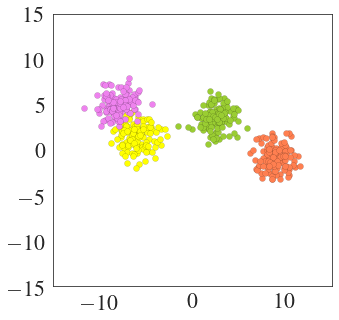

In [3]:
np.random.seed(7777)
size = 500
train_range = (-10, 10)

X, Y = datasets.make_blobs(n_samples=size, centers=4, cluster_std=1.2, 
                           center_box=train_range, random_state=37)

# train_range = (-5, 5)
test_range = (-15, 15)

plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.1)
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.1)
plt.scatter(X[Y==2][:, 0], X[Y==2][:, 1], c='yellowgreen', edgecolors='k', linewidths=0.1)
plt.scatter(X[Y==3][:, 0], X[Y==3][:, 1], c='violet', edgecolors='k', linewidths=0.1)
plt.xlim(test_range);
plt.ylim(test_range);


def add_bias_term(X):
    return np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)

In [4]:
torch.manual_seed(99999)

m, n = X.shape
h = 20
k = 4

X_t = torch.from_numpy(X).float()
Y_t = torch.from_numpy(Y).long()


class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU(),
#             nn.Linear(h, h), 
#             nn.BatchNorm1d(h),
#             nn.ReLU(),
        )

        self.clf = nn.Linear(h, k, bias=False)
    
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)
    
    
model = Model()
print(np.sum([p.numel() for p in model.parameters()]))
    
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
# opt = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

# pbar = trange(5000, position=0, leave=True)
pbar = range(5000)
for it in pbar:
    y = model(X_t)
    l = F.cross_entropy(y, Y_t, reduction='mean')
    l.backward()
    opt.step()
    opt.zero_grad()
    
#     pbar.set_description(f'Loss: {l.item():.3f}')
    
print(f'Loss: {l.item():.3f}')

# torch.save(model.state_dict(), 'pretrained_models/relu_bnn_clf_2d.th')

640
Loss: 0.043


7.046618791430515
torch.Size([4, 20])
96
8.5


100%|██████████| 2500/2500 [00:13<00:00, 188.16it/s]


(2500, 4)
[0.4167025]
[0.28090736]
[0.28100038]
[0.26157492]


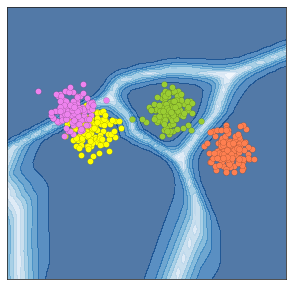

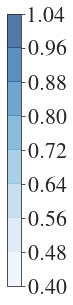

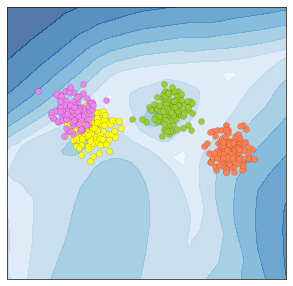

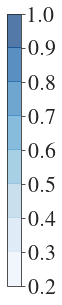

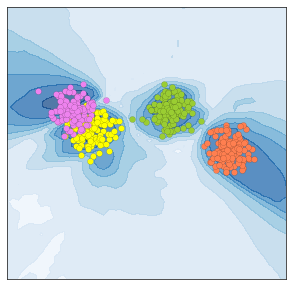

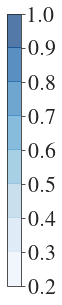

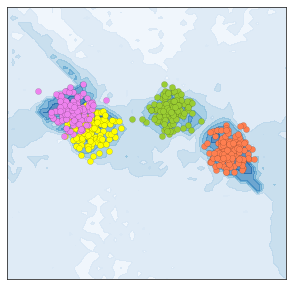

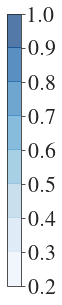

In [7]:
model.eval()

# Val data
X_val, y_val = datasets.make_blobs(n_samples=50, centers=4, cluster_std=1.2, 
                           center_box=train_range, random_state=1231231)
X_val, y_val = torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long()

# Test data
size = 50
test_rng = np.linspace(*test_range, size)
X1_test, X2_test = np.meshgrid(test_rng, test_rng)
X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T

X_test_t = torch.from_numpy(X_test).float()


''' ============================== MAP ================================='''

with torch.no_grad():
    model.eval()
    py_map = F.softmax(model(X_test_t), 1).squeeze().numpy()

entropy_map = -np.sum(py_map*np.log(py_map+1e-8), axis=1)
entropy_map = py_map.max(1)


''' ============================== Temp ================================='''

with torch.no_grad():
    logit_val = model(X_val).cpu().numpy()
    T = TemperatureScaling().fit(logit_val, y_val.numpy()).T
    print(T)

    logit_test = model(X_test_t)
    py_temp = torch.softmax(logit_test/T, 1).numpy()
    entropy_temp = -np.sum(py_temp*np.log(py_temp+1e-8), axis=1)
    
entropy_temp = py_temp.max(1)
    

''' ============================== LLLA ================================='''

from hessian import exact_hessian
from torch.distributions.multivariate_normal import MultivariateNormal
torch.set_printoptions(precision=1, profile='full')


W = list(model.parameters())[-1]
shape_W = W.shape
print(shape_W)

var0 = 10


def neg_log_post():
    nll = F.cross_entropy(model(X_t), Y_t, reduction='sum')
    nlp = 1/2 * W.flatten() @ (1/var0 * torch.eye(W.numel())) @ W.flatten()

    return nll + nlp


def llla_predict(x, var0, apply_sigm=True):
    model.eval()
    loss = F.cross_entropy(model(X_t), Y_t, reduction='sum')
    Prec_post = exact_hessian(loss, [W])
    Cov_post = torch.inverse(1/var0*torch.eye(W.numel()) + Prec_post)

    with torch.no_grad():
        post = MultivariateNormal(W.flatten(), Cov_post)

        # MC-estimate
        n_sample = 100
        py = 0

        phi_test = model.feature_extr(x)

        for _ in range(n_sample):
            W_s = post.rsample().view(shape_W)
            py += torch.softmax(phi_test @ W_s.t(), 1)

        py /= n_sample

    return py.numpy()


def optimize_var0(x_val, y_val):
    var0s = np.linspace(0.0001, 100, 100)
    nlls = []
    X_out = torch.from_numpy(np.random.uniform(*train_range, size=[50, 2])).float()    
    
    pbar = tqdm(var0s, position=0, leave=True)

    for var0 in pbar:
        out_in = llla_predict(x_val, var0)
        out_in = torch.from_numpy(out_in).float()
        loss = F.nll_loss(torch.log(out_in), y_val).detach().item()
        
        out_out = llla_predict(X_out, var0)
        loss += np.mean(np.sum(-1/4 * np.log(out_out), 1))
        
        nlls.append(loss)
        pbar.set_description(f'var0: {var0:.3f}, Loss: {loss:.3f}')
            
    best_var0 = var0s[np.argmin(nlls)]

    return best_var0


# var0 = optimize_var0(X_val, y_val)
var0 = 96  # Optimal value from the above
print(var0)

py_llla = llla_predict(X_test_t, var0)
# entropy_llla = -np.sum(py_llla*np.log(py_llla + 1e-8), axis=1)
entropy_llla = py_llla.max(1)

    
''' ============================== Full-Laplace ================================='''

from laplace import diag_laplace

model_full = diag_laplace.DiagLaplace(model)
interval = np.linspace(0.0001, 10, 100)
# var0 = model_full.optimize_var0_multi(X_t, Y_t, X_val, y_val, interval, rng_ood=train_range)
var0 = 8.5  # This is the optimal value

print(var0)

model_full.estimate_variance_batch(X_t, Y_t, var0, multiclass=True)

# print(model_full.hessian); input()

py_full = model_full.forward_linearized_multi(X_test_t).detach().numpy()
print(py_full.shape)
# entropy_full = -np.sum(py_full*np.log(py_full + 1e-8), axis=1)

entropy_full = py_full.max(1)

# print(py_map.shape)

    
# plot_aux_mc(X, Y, X1_test, X2_test, py_map.reshape(size, size), entropy_map.reshape(size, size), 'ent_toy_2d_nn_multiclass_map')
# plot_aux_mc(X, Y, X1_test, X2_test, py_temp.reshape(size, size), entropy_temp.reshape(size, size), 'ent_toy_2d_nn_multiclass_temp')
# plot_aux_mc(X, Y, X1_test, X2_test, py_llla.reshape(size, size), entropy_llla.reshape(size, size), 'ent_toy_2d_nn_multiclass_llla_exact')
# plot_aux_mc(X, Y, X1_test, X2_test, py_fullla.reshape(size, size), entropy_full.reshape(size, size), 'ent_toy_2d_nn_multiclass_fullla')

print(entropy_map[entropy_map == entropy_map.min()])
print(entropy_temp[entropy_temp == entropy_temp.min()])
print(entropy_llla[entropy_llla == entropy_llla.min()])
print(entropy_full[entropy_full == entropy_full.min()])

plot_aux_mc(X, Y, X1_test, X2_test, entropy_map.reshape(size, size), 'ent_toy_2d_nn_multiclass_map')
plot_aux_mc(X, Y, X1_test, X2_test, entropy_temp.reshape(size, size), 'ent_toy_2d_nn_multiclass_temp')
plot_aux_mc(X, Y, X1_test, X2_test, entropy_llla.reshape(size, size), 'ent_toy_2d_nn_multiclass_llla_exact')
plot_aux_mc(X, Y, X1_test, X2_test, entropy_full.reshape(size, size), 'ent_toy_2d_nn_multiclass_fullla')